### EvalSuite -> compareTrackers via largestDiscrepancy()
After viewing summary stats for difference between trackers, drilldown into individual frames at the frames where difference is the largest.

In [81]:
import pandas as pd
import sqlalchemy
import numpy as np
import os, sys, copy, random, pickle, cv2, math
from matplotlib import pyplot as plt
%matplotlib inline
sys.path.append("../")
%load_ext autoreload
%autoreload 2
from modules.ControlTracking import TrackFactory
from modules.ControlDisplay import Display
from modules.Interproc import DBInterface, GuiviewState
from modules.AnalysisHelpers import ( 
         exploreImgs, buildImgComparisonData, subprocEval,
        subprocBatchOutput, cvtPlot, applyTracker,
        roiSelectScoreWindow, multiPlot, compareTrackers)
from modules.EvalHelpers import EvalTracker, EvalDataset
from modules.ControlEval import EvalFactory
from modules.DataSchemas import ScoreSchema
from modules.EvalHelpers import OutcomeData, DFHelper
from modules.EvalHelpers import AggEval, DFHelper
from modules.EvalSuite import EvalSuite, CmpAlgoReport
from IPython.display import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
db_path = 'data/misc/books/eval-report-3/'

outcome_0 = OutcomeData(dbPathFn = db_path + 'algo_0.db')
outcome_1 = OutcomeData(dbPathFn = db_path + 'algo_1.db')
outcome_2 = OutcomeData(dbPathFn = db_path + 'algo_2.db')

In [82]:
cmpA = CmpAlgoReport(benchmark_outcome_data = outcome_0.getOutcome(), 
                     current_outcome_data = outcome_2.getOutcome()
                    )

,improvements,deprovements,sames
checkTrackSuccess,0.000,0.000,345.000


,improvements,deprovements,sames
calcBaselineBallUnitsAway,7,3,9
checkBothContainsOther,3,0,16
checkTrackSuccess,0,0,19
distanceFromBaseline,7,3,9


,diff,current,benchmark
,mean,mean,mean
agg_checkTrackSuccess,0.000,1.000,1.000
agg_calcBaselineBallUnitsAway,0.047,-0.381,-0.429
agg_checkBothContainsOther,0.158,0.579,0.421
agg_distanceFromBaseline,0.366,-5.125,-5.491


diff        current          benchmark  \
                                   mean      n    mean        n      mean   
fagg_less_than_20_pix_balls_away  0.060  0.000  -0.436   16.000    -0.496   
fagg_less_than_30_pix_success     0.000  0.000   1.000  310.000     1.000   

                                           
                                        n  
fagg_less_than_20_pix_balls_away   16.000  
fagg_less_than_30_pix_success     310.000

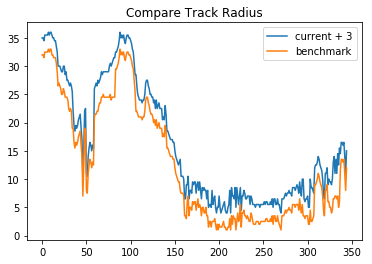

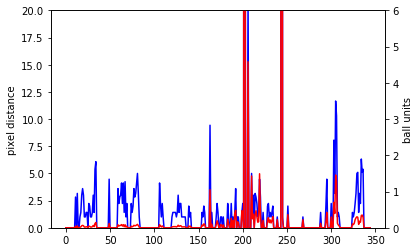

In [79]:
cmpA.report1()

In [92]:
cmpA.reportDiscrepancy(metric_name='distanceBetweenTracks', metric_val=1, vid_fn='')

244   -304.685083
202   -283.019434
206    -20.615528
305    -11.661904
306    -10.295630
dtype: float64

In [105]:
from modules.AnalysisHelpers import compareTrackers
from modules.EvalSuite import CmpAlgoReport

In [106]:
cmpB = CmpAlgoReport(benchmark_outcome_data = outcome_0.getOutcome(), 
                     current_outcome_data = outcome_2.getOutcome()
                    )

In [107]:
[_tracker.tp_trackAlgoEnum for _tracker in listTrackers]

[0, 1, 2]

("Unknown format code 'f' for object of type 'str'", u'occurred at index (current, checkBaselineInsideTrack)')


244   -304.685083
202   -283.019434
206    -20.615528
305    -11.661904
306    -10.295630
dtype: float64

runnning subprocBathcOutput, takes 5-30 seconds


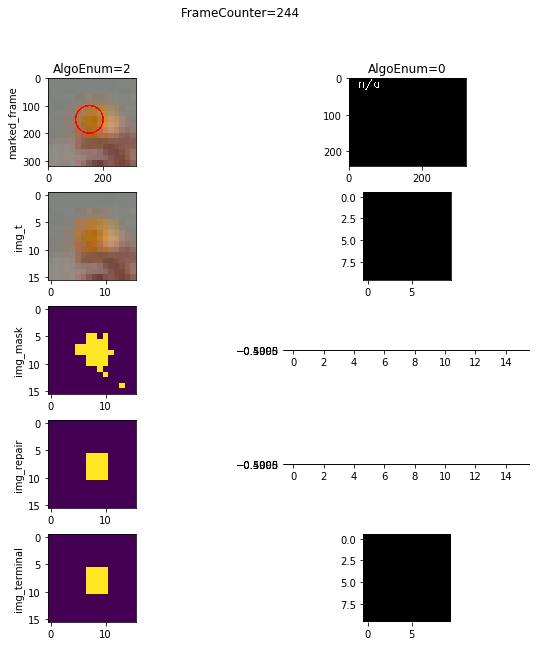

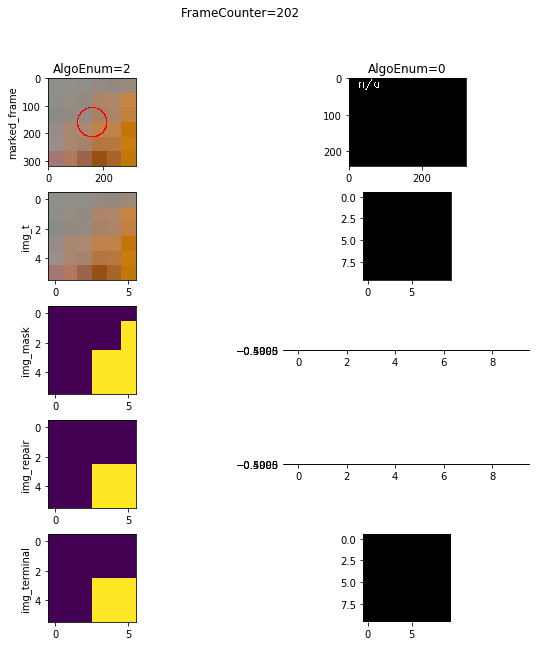

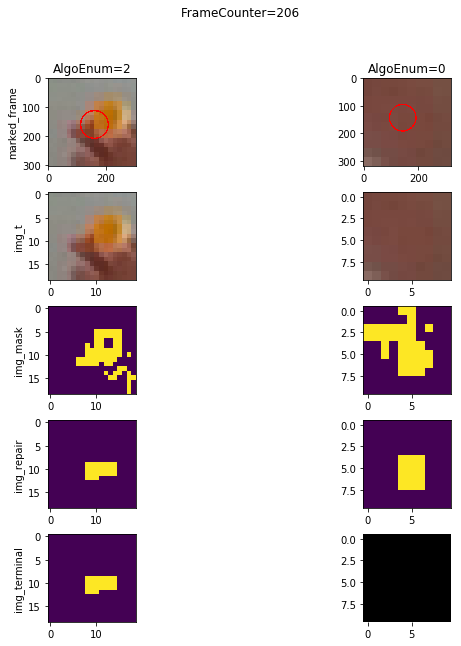

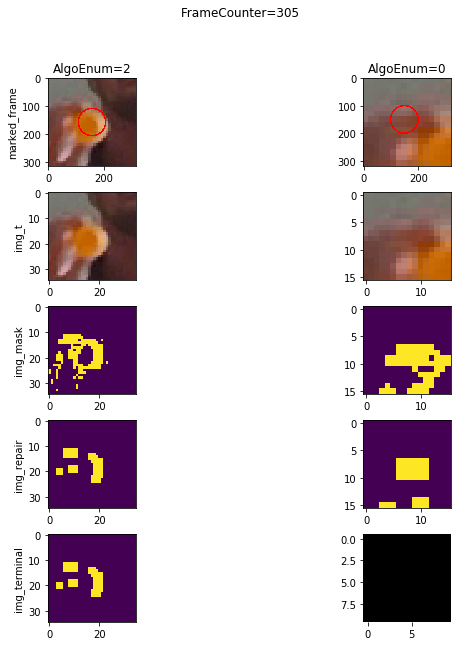

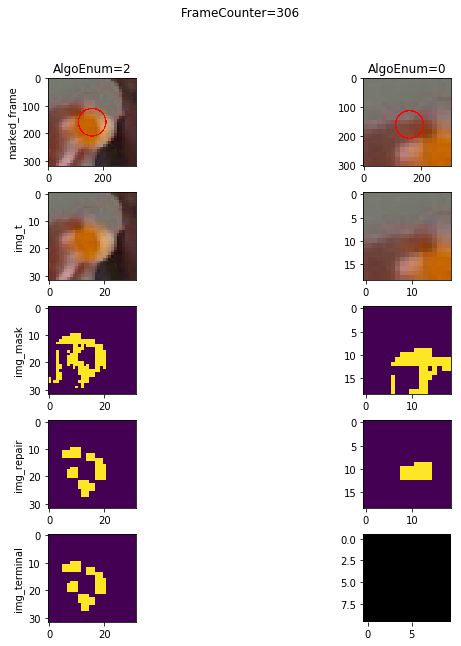

In [108]:
cmpB.reportDiscrepancy(metric_name='distanceBetweenTracks'
                      ,metric_val=1
                      ,vid_fn = 'data/proc/tmp/dec14/output5.proc1.proc1.avi'
                      ,current_algo = listTrackers[2]
                      ,benchmark_algo = listTrackers[0]
                      ,b_ret=False
                      )

In [80]:
discrep_distance = cmpA.largestDiscrepancy(distanceBetweenTracks=1, max_n=5)
display(discrep_distance)

discrep_ballsaway = cmpA.largestDiscrepancy(ballUnitsBetweenTracks=1, max_n=5)
display(discrep_ballsaway)


("Unknown format code 'f' for object of type 'str'", u'occurred at index (current, checkBaselineInsideTrack)')


244   -304.685083
202   -283.019434
206    -20.615528
305    -11.661904
306    -10.295630
dtype: float64

202   -113.207774
244    -60.937017
206     -4.581228
219     -1.490712
305     -1.457738
dtype: float64

In [62]:
DATA_DIR = "../data/misc/books/compare-tracker-gallery-1/"
gs_db = "compareTrackers_orange.db"
diff_db = "compareTrackers_disparateRoi.db"

# build listGS
testDB = DBInterface(os.path.join(DATA_DIR, gs_db))
inputGS = [  pickle.loads(record[1])
            for record in testDB.selectAll()]
print 'inputGS frame_indexes=', str([_gs.frameCounter for _gs in inputGS])

list frame_indexes= [78, 187, 195, 215, 295, 307]


In [63]:
foi = list(discrep_ballsaway.index)
vid_fn = 'data/proc/tmp/dec14/output5.proc1.proc1.avi'
foiGS = subprocBatchOutput(vid_fn, batch_list = foi)
print 'foiGS frame_indexes=', str([_gs.frameCounter for _gs in foiGS])


START - running batch output ...
...deleting all exisiting data/usr/batch_tmp.db records...
FINISH - batch output with 5 outputs.
foiGS frame_indexes= [202, 206, 210, 244, 305]


In [93]:
foi

[202L, 244L, 206L, 210L, 305L]

In [96]:
def sortGS(listGS, foi):

    listGS.sort(key=lambda gs: foi.index(gs.frameCounter), reverse=False )
    
    return listGS

print [_gs.frameCounter for _gs in listGS]
listGS = sortGS(foiGS, foi)
print foi
print [_gs.frameCounter for _gs in listGS]

[78, 187, 195, 215, 295, 307]
[202L, 244L, 206L, 210L, 305L]
[202, 244, 206, 210, 305]


In [64]:
listTrackers = []
for _algoenum in [0,1,2]:
    _tracker = TrackFactory(on=True)
    _tracker.setAlgoEnum(_algoenum)
    _tracker.setInit(ballColor="orange")
    listTrackers.append(_tracker)
print 'list algo_enums=', str([_tracker.tp_trackAlgoEnum for _tracker in listTrackers])

list algo_enums= [0, 1, 2]


In [70]:
gs_of_interest = foiGS[0]
tracker_of_interest = listTrackers[0]
print 'frameindex: %s' % str(gs_of_interest.frameCounter)
print 'trackerenum: %s' % str(tracker_of_interest.tp_trackAlgoEnum)

track0_frame202 = applyTracker([gs_of_interest], tracker_of_interest)

gs_of_interest = foiGS[0]
tracker_of_interest = listTrackers[2]
print 'frameindex: %s' % str(gs_of_interest.frameCounter)
print 'trackerenum: %s' % str(tracker_of_interest.tp_trackAlgoEnum)

track2_frame202 = applyTracker([gs_of_interest], tracker_of_interest)

print track0_frame202['listScore']
print track2_frame202['listScore']

frameindex: 202
trackerenum: 0
frameindex: 202
trackerenum: 2
[{'0': {'type': 'circle', 'data': [401, -1, 3, 3]}}]
[{'0': {'type': 'circle', 'data': [377, 281, 2, 2]}}]


In [72]:
#manually calc distance
(((401 - 377)**2) + ((281 - -1)**2))**(0.5)

283.0194339616981

##### Build pre-req's for comparison plot: listTrackers, listGS

In [7]:
foi = list(discrep_ballsaway.index)
foi

[202L, 244L, 206L, 210L, 305L]

In [8]:
vid_fn = 'data/proc/tmp/dec14/output5.proc1.proc1.avi'
listGS = subprocBatchOutput(vid_fn, batch_list = foi)


START - running batch output ...
...deleting all exisiting data/usr/batch_tmp.db records...
FINISH - batch output with 5 outputs.


In [9]:
[_gs.frameCounter for _gs in listGS]

[202, 206, 210, 244, 305]

In [10]:
vid_fn = 'data/proc/tmp/dec14/output5.proc1.proc1.avi'
listGS2 = subprocBatchOutput(vid_fn, batch_list = [0,1,2])


START - running batch output ...
...deleting all exisiting data/usr/batch_tmp.db records...
FINISH - batch output with 3 outputs.


In [31]:
[_gs.frameCounter for _gs in listGS2]

[0, 1, 2]

In [12]:
listTrackers = []
for _algoenum in [0,2]:
    _tracker = TrackFactory(on=True)
    _tracker.setAlgoEnum(_algoenum)
    _tracker.setInit(ballColor="orange")
    listTrackers.append(_tracker)
print 'algo_enums=', str([_tracker.tp_trackAlgoEnum for _tracker in listTrackers])

algo_enums= [0, 2]


In [13]:
listTrackers.sort(reverse=True)

In [14]:
print 'algo_enums=', str([_tracker.tp_trackAlgoEnum for _tracker in listTrackers])

algo_enums= [2, 0]


##### Build Test Data

In [39]:
TEST_PARENT_DIR = "../data/test/analysishelpers/"
test_data = "compareTrackers_disparateRoi.db"
test_dir = os.path.join(TEST_PARENT_DIR, 'compareTrackers')
testDB = DBInterface(os.path.join(test_dir, test_data))

In [37]:
for _gs in listGS:
    testDB.insertState(_gs.save())

In [38]:
testDB=None

In [40]:
testGS = [  pickle.loads(record[1])
                for record in testDB.selectAll()]

In [41]:
[_gs.frameCounter for _gs in testGS]

[202, 206, 210, 244, 305]

##### Comparison Plots

In [46]:
from modules.AnalysisHelpers import compareTrackers

### Here's a classic plot

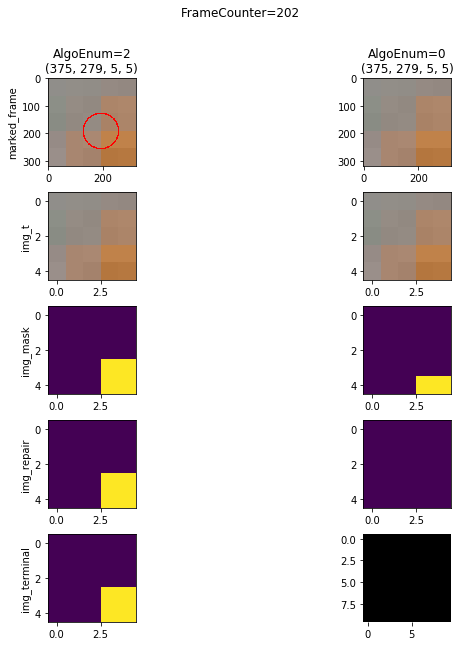

In [50]:
compareTrackers([listGS[0]]
                ,listTrackers
                ,roiSelectFunc=True
                ,bMarkedFrame=True
                ,bTrackScore=True
                ,bFirstTrackerRoi=True
                ,expand_factor=5.0
               )

(376, 280, 5, 5)
(399, -3, 7, 7)


c:\python27\lib\site-packages\matplotlib\axes\_base.py:3471: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  'bottom=%s, top=%s') % (bottom, top))


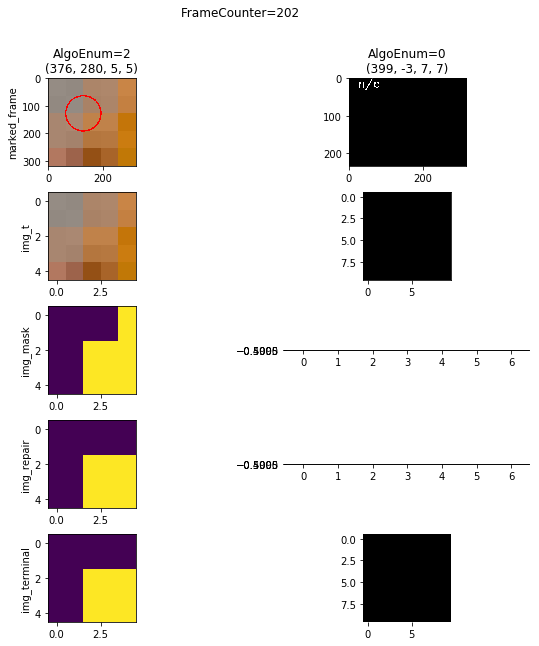

In [35]:
compareTrackers([listGS[0]]
                ,listTrackers
                ,roiSelectFunc=True
                ,bMarkedFrame=True
                ,bTrackScore=True
                ,bFirstTrackerRoi=False
                ,expand_factor=2.0
               )

video / metalog information 

num frames:                  345 
obj enums scored/tracked:    0,1 / 0 
num scored frames:           19 | 0,9,78...308,324,340 
-------

select aggregates 



agg_calcBaselineBallUnitsAway   -0.407282
agg_checkBothContainsOther       0.578947
agg_checkTrackSuccess            1.000000
Name: mean, dtype: float64

,mean,n
fagg_less_than_20_pix_balls_away,-0.466989,16.0
fagg_less_than_30_pix_success,1.000000,310.0


plotting radius comparison 



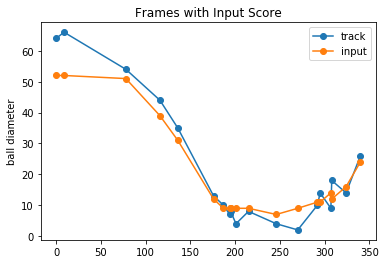

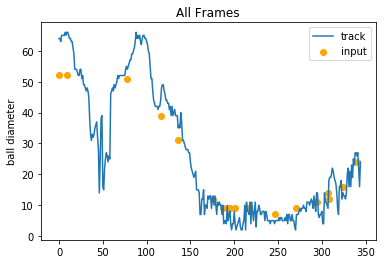


full eval table on input frames 



,calc Baseline Ball Units Away,check Both Contains Other,distance From Baseline,check Track Success,prop Track Radius,check Baseline Inside Track,check Either Contains Other,check Track Inside Baseline,check Track Inside Baseline Rect,compare Radii,prop Baseline Radius
0,-0.04,True,-2,True,32,True,True,True,False,6,26.0
9,-0.14,True,-7,True,33,True,True,True,False,7,26.0
78,-0.08,True,-4,True,27,True,True,True,False,2,25.0
116,-0.12,True,-4,True,22,True,True,True,False,3,19.0
136,-0.14,True,-4,True,17,True,True,True,False,2,15.0
176,-0.42,True,-5,True,6,True,True,True,False,0,6.0
187,-0.53,False,-4,True,5,True,True,False,False,1,4.0
194,-0.76,False,-6,True,3,False,False,False,False,-1,4.0
195,-0.38,True,-3,True,4,True,True,True,False,0,4.0
201,-0.52,False,-4,True,2,False,False,False,False,-2,4.0



a preview of each eval dataframe


agg_calcBaselineBallUnitsAway   -0.407282
agg_checkBaselineInsideTrack     0.684211
agg_checkBothContainsOther       0.578947
Name: mean, dtype: float64

,mean,n
fagg_less_than_20_pix_balls_away,-0.466989,16.0
fagg_less_than_30_pix_success,1.000000,310.0


,calc Baseline Ball Units Away,check Both Contains Other,distance From Baseline,check Track Success,prop Track Radius,check Baseline Inside Track,check Either Contains Other,check Track Inside Baseline,check Track Inside Baseline Rect,compare Radii,prop Baseline Radius
0,-0.04,True,-2,True,32,True,True,True,False,6,26.0
9,-0.14,True,-7,True,33,True,True,True,False,7,26.0
78,-0.08,True,-4,True,27,True,True,True,False,2,25.0


,index,input _data0 _0,input _data0 _1,input _data0 _2,input _data0 _3,input _data1 _0,input _data1 _1,input _data1 _2,input _data1 _3,input _data2 _0,...,track _data3 _2,track _data3 _3,track _obj _exists _0,track _obj _exists _1,track _obj _exists _2,track _obj _exists _3,track _obj _type _0,track _obj _type _1,track _obj _type _2,track _obj _type _3
0,0,107.0,111.0,None,None,214.0,218.0,None,None,54.0,...,None,None,True,None,None,None,circle,None,None,None
1,1,NaN,NaN,None,None,NaN,NaN,None,None,NaN,...,None,None,True,None,None,None,circle,None,None,None
2,2,NaN,NaN,None,None,NaN,NaN,None,None,NaN,...,None,None,True,None,None,None,circle,None,None,None


In [30]:
cmpA.current.displayFullReport()

### Build Tests